# import data

In [1]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


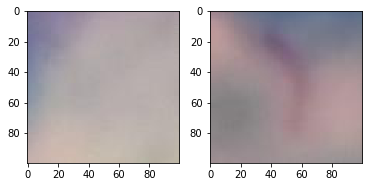

In [2]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.int)
X_val = X_val.astype(np.int)
y_train = y_train.astype(np.int)
y_val = y_val.astype(np.int)

# change into one-hot vector
y_train = tf.keras.utils.to_categorical(y_train, 2) 
y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

## Define trainning function

In [3]:
def train_data(model):
    loss = []
    acc = []
    val_loss = []
    val_acc = []
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
    hist = model.fit(X_train, y_train,
                     batch_size=64,
                     epochs=50,  # Run thru all the data point in each epoch
                     verbose=1,
                     validation_data=(X_val, y_val),
                     #callbacks=[tensorboard])
                     callbacks=[early_stop, tensorboard])
    #val_err.append(hist.history['val_mean_absolute_error'][-1]) # a dict
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
    acc.append(hist.history['acc'][-1])
    val_acc.append(hist.history['val_acc'][-1])   
    
    return loss, val_loss, hist

## Define a VGG network

In [9]:
def VGG(activ):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=activ, input_shape=(100, 100, 3)),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation=activ),
        tf.keras.layers.Dense(4096, activation=activ),
        tf.keras.layers.Dense(1000, activation=activ),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    param = model.count_params()
    model.compile(optimizer=tf.train.AdamOptimizer(0.000001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
   

    model.summary()
    
    return model, param

## Define a DNN model

In [22]:
def dnnmodel(n, activ, param):
    model = tf.keras.Sequential([])
    model.add(tf.keras.layers.Flatten(input_shape=(100, 100, 3)))
    for i in range(n):
        model.add(tf.keras.layers.Dense(100, activation=activ))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    # model.summary()
    # model.count_params()
    param.append(model.count_params())
    model.compile(optimizer=tf.train.AdamOptimizer(0.000001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'mae'])
    return model, param

## Trainning with VGG

### VGG with activation "relu"

In [10]:
activ = 'relu'
model_VGG1, param_VGG1 = VGG(activ)
loss_VGG1, val_loss_VGG1, hist_VGG1= train_data(model_VGG1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 256)       590080    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 256)       0         
__________

### Define the function for plots

In [ ]:
def plot_acc_and_loss(hist):
    acc = hist['acc']
    loss = hist['loss']
    val_acc = hist['val_acc']
    val_loss = hist['val_loss']
    
    plt.plot(acc, 'r-o')
    plt.title("Trainning accuracy")
    plt.show()
    
    plt.plot(loss, 'g-o')
    plt.title("Trainning loss")
    plt.show()
    
    plt.plot(val_acc, 'b-o')
    plt.title("Validation accuracy")
    plt.show()
    
    plt.plot(val_loss, 'm-o')
    plt.title("Validation loss")
    plt.show()

In [ ]:
plot_acc_and_loss(hist_VGG1)

### Define function for statistics calculation

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_val)
y_val = np.argmax(y_val, axis=-1)
predictions = np.argmax(predictions, axis=-1)
c = confusion_matrix(y_val, predictions)
print('Confusion matrix:\n', c)
print('sensitivity', c[0, 0] / (c[0, 1] + c[0, 0]))
print('specificity', c[1, 1] / (c[1, 1] + c[1, 0]))

In [11]:
loss1 = []
val_loss1 =[]
param1 = []
activ = 'tanh'
model, param1 = VGG_cifar100(activ)

loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 256)       590080    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 256)       0         
__________

## DNN

In [23]:
loss1 = []
val_loss1 =[]
param1 = []
activ = 'relu'
model, param1 = dnnmodel(15, activ, param1)
loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

Train on 7268 samples, validate on 808 samples
Epoch 1/50
7268/7268 [==============================] - 3s 408us/sample - loss: 0.7768 - acc: 0.4600 - mean_absolute_error: 0.5133 - val_loss: 0.6988 - val_acc: 0.4963 - val_mean_absolute_error: 0.5004
Epoch 2/50
7268/7268 [==============================] - 2s 272us/sample - loss: 0.6841 - acc: 0.5976 - mean_absolute_error: 0.4937 - val_loss: 0.6761 - val_acc: 0.6077 - val_mean_absolute_error: 0.4896
Epoch 3/50
7268/7268 [==============================] - 2s 275us/sample - loss: 0.6730 - acc: 0.6054 - mean_absolute_error: 0.4874 - val_loss: 0.6701 - val_acc: 0.5829 - val_mean_absolute_error: 0.4850
Epoch 4/50
7268/7268 [==============================] - 2s 276us/sample - loss: 0.6587 - acc: 0.6286 - mean_absolute_error: 0.4787 - val_loss: 0.6519 - val_acc: 0.6300 - val_mean_absolute_error: 0.4738
Epoch 5/50
7268/7268 [==============================] - 2s 280us/sample - loss: 0.6495 - acc: 0.6439 - mean_absolute_error: 0.4716 - val_loss: 0.

## ResNet

In [28]:
from tensorflow.keras.applications import ResNet50

def resnet():
    input_tensor = tf.keras.layers.Input(shape=(100, 100, 3))
    model = ResNet50(include_top=True, weights=None, input_tensor=input_tensor, input_shape=None, pooling=None, classes=2)
    param = model.count_params()
    model.compile(optimizer=tf.train.AdamOptimizer(0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model, param

In [29]:
loss1 = []
val_loss1 =[]
param1 = []
model, param = resnet()
loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 50, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Epoch 1/50
7268/7268 [==============================] - 22s 3ms/sample - loss: 0.6956 - acc: 0.5557 - val_loss: 3.2630 - val_acc: 0.5656
Epoch 2/50
7268/7268 [==============================] - 16s 2ms/sample - loss: 0.6496 - acc: 0.6095 - val_loss: 0.7184 - val_acc: 0.6089
Epoch 3/50
7268/7268 [==============================] - 16s 2ms/sample - loss: 0.6306 - acc: 0.6379 - val_loss: 0.6427 - val_acc: 0.6250
Epoch 4/50
7268/7268 [==============================] - 16s 2ms/sample - loss: 0.6004 - acc: 0.6783 - val_loss: 0.6067 - val_acc: 0.6708
Epoch 5/50
7268/7268 [==============================] - 16s 2ms/sample - loss: 0.5615 - acc: 0.7133 - val_loss: 0.5849 - val_acc: 0.6918
Epoch 6/50
7268/7268 [==============================] - 16s 2ms/sample - loss: 0.5200 - acc: 0.7367 - val_loss: 0.5430 - val_acc: 0.7401
Epoch 7/50
7268/7268 [==============================] - 16s 2ms/sample - loss: 0.4868 - acc: 0.7577 - val_loss: 0.5114 - val_acc: 0.7587
Epoch 8/50
7268/7268 [===================

In [ ]:
def add_3_channel(X):
    new = []
    for image in X:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
        add = r+g+b
        new.append(add)
    return np.array(new)

In [ ]:
X_train = add_3_channel(X_train)
X_val = add_3_channel(X_val)

In [ ]:
# Example CNN used in class
def VGG_gray(activ):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=activ, input_shape=(100, 100)),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation=activ),
        tf.keras.layers.Dense(4096, activation=activ),
        tf.keras.layers.Dense(1000, activation=activ),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    param = model.count_params()
    model.compile(optimizer=tf.train.AdamOptimizer(0.000001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
   

    model.summary()
    
    return model, param

In [ ]:
loss1 = []
val_loss1 =[]
param1 = []
activ = 'relu'
model, param1 = VGG_gray(activ)
loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

## simulating a microscope

In [4]:
# cast as a float32:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

### Convert the dataset into microscope samples

In [6]:
wavelength = .5
thickness = 1 * wavelength

def convert_dataset(X, wavelength, thickness):
    X1 = X / np.max(X)
    X2 = np.exp(1j * X1 * thickness / wavelength)
    return X2

X_train = convert_dataset(X_train, wavelength, thickness)
X_val = convert_dataset(X_val, wavelength, thickness)

### create input pipeline for generating training/testing batches

In [40]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [3, 100, 100], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

### create complex-valued trainable illumination

In [41]:
# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = True  

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.Variable(tf.random_uniform([100,100]),dtype=np.float32,trainable=train_illumination)
input_illumination_phase = tf.cast(input_illumination_phase, tf.complex64)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*input_illumination_phase)

### generate the emerging field from the sample and propagate the emerging field to the aperture plane

In [42]:
# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = X_batch * input_illumination
aperture_plane = tf.fft2d(emerging_field)

### create complex-valued trainable aperture function

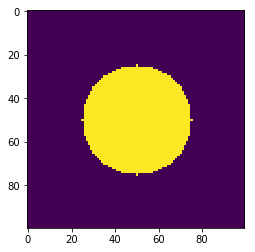

In [45]:
# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = True

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
r = 0.25 * 100
circ_aper1 = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        if (i-50)**2+(j-50)**2 <= r**2:
            circ_aper1[i,j] = 1

plt.imshow(circ_aper1)
circ_aper2 = np.dstack([circ_aper1,circ_aper1,circ_aper1])
circ_aper = np.fft.fftshift(circ_aper1)

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.Variable(tf.random_uniform([100,100]),dtype=np.float32)
aperture_phase = tf.cast(aperture_phase, tf.complex64)

# write the full aperture function, combining the above two components:
aperture = circ_aper * tf.exp(1j * aperture_phase)

# filter the field that you propagated:
aperture_plane_filtered = aperture_plane * aperture

### propagate to the image plane

In [46]:
# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = (tf.abs(tf.ifft2d(aperture_plane_filtered)))**2
#image = tf.abs(tf_fftshift2(tf.fft2d(tf_ifftshift2(aperture_plane_filtered))))**2

# add noise:
#image += tf.random_normal([100,100],stddev=0.05)

### process the simulated image through a CNN

In [48]:
net = image[..., None]  # add a channels dimension

# define your CNN here

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=10)

logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.01).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

D:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [49]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

ValueError: Cannot feed value of shape (7268, 100, 100, 3) for Tensor 'input_image_3:0', which has shape '(3, 100, 100)'

In [ ]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [ ]:
# train loop:
correct = 0
total = 0
for i in range(10000):
    _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
    if i%1000 == 0:
        print(loss_i)
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Accuracy is:")
print(acc)

In [ ]:
# plot examples 
plot_examples(image.eval())

In [ ]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})

# pass through test set:
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Test accuracy is:")
print(acc)